# Определение возраста по фото (Keras)

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя.

# Исследовательский анализ данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")

Загрузим датасет в генератор `ImageDataGenerator`

In [ ]:
#инициализируем генератор
datagen = ImageDataGenerator()

#прописываем пути к файлам в переменные
path_folder = '/datasets/faces/final_files/'
path_csv = '/datasets/faces/labels.csv'

#передаём в генератор данные из датафрейма и папки с фотографиями
df = pd.read_csv(path_csv)
train_datagen = datagen.flow_from_dataframe(dataframe=df,
                                            directory=path_folder,
                                            x_col='file_name',
                                            y_col='real_age',
                                            batch_size=16,
                                            class_mode="input",
                                            seed=12345)

In [ ]:
df.shape

(7591, 2)

В выбоке 7591 объект, чего должно быть достаточно для дообучения модели.  

**Оценим распределение целевого признака.**

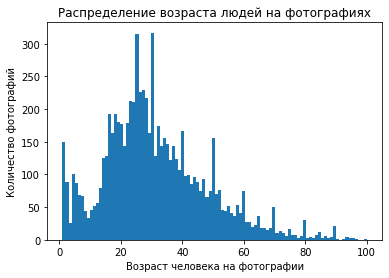

In [ ]:
plt.hist(df['real_age'], bins=100)
plt.title('Распределение возраста людей на фотографиях')

plt.xlabel('Возраст человека на фотографии')
plt.ylabel('Количество фотографий')
plt.show();

В данных можество значений в районе 0, а также выбивающиеся пики на "круглых" числах. Вероятнее всего не было точных данных о возрасте людей на фотографиях и датасет размечали "на глаз", что может сказаться на качестве моделей.  
В целом данные выглядят естественно.  

**Оценим изображения датасета**

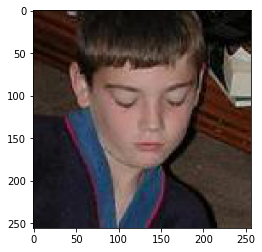

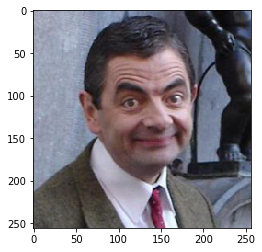

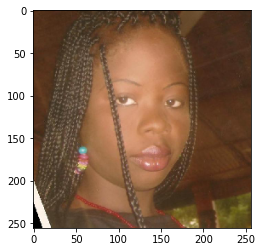

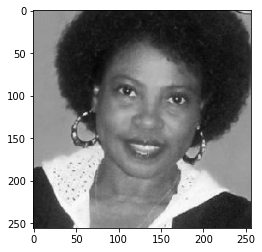

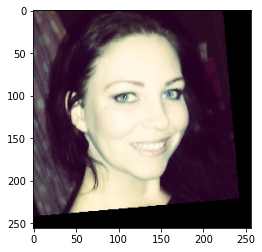

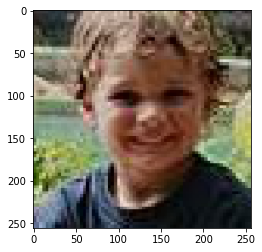

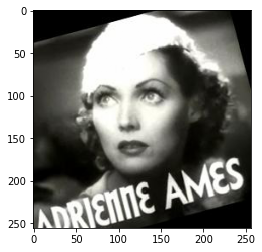

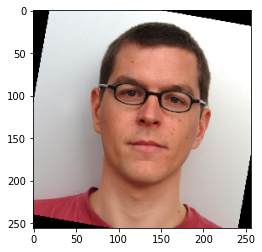

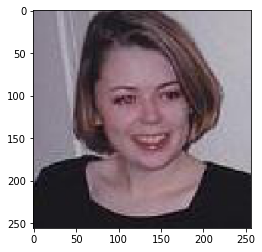

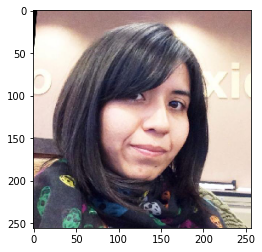

In [33]:
#циклом выведем 10 изображений
for _ in range(10):
     image, label = train_datagen.next()
     plt.imshow(image[0]/255)
     plt.show()

Изображения цветные, но встречаются ч/б, некоторые из них повёрнуты, обрезаны, смещены в сторону. Качество изображений различное.    
На изображениях исходного датасета видно, что аугментация уже проведена, следовательно мы её делать не станем.  
В выборке достаточно данных, аномалий целевого признака не обнаружено.  
Данные готовы к обучению модели.  

## Обучение модели

Будем использовать ResNet50

В этом разделе вычисления производились на [Yandex Compute Cloud](https://cloud.yandex.ru/services/compute)

In [ ]:
optimizer = Adam(lr=0.0001)

# Загрузка обучающей выборки
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25,
                                    rescale=1./255
                                )

    path_folder = '/datasets/faces/final_files/'
    path_csv = '/datasets/faces/labels.csv'

    df = pd.read_csv(path_csv)
    train_datagen = datagen.flow_from_dataframe(dataframe=df,
                                                directory=path_folder,
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(150, 150),
                                                batch_size=16,
                                                subset='training',
                                                class_mode="raw",
                                                seed=12345)

    return train_datagen

# Загрузка валидационной выборки
def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25,
                                    rescale=1./255
                                )

    path_folder = '/datasets/faces/final_files/'
    path_csv = '/datasets/faces/labels.csv'

    df = pd.read_csv(path_csv)
    test_datagen = datagen.flow_from_dataframe(dataframe=df,
                                                directory=path_folder,
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(150, 150),
                                                batch_size=16,
                                                subset='validation',
                                                class_mode="raw",
                                                seed=12345)

    return test_datagen

# Создание модели на архитектуре ResNet50
def create_model(input_shape):
    backbone = ResNet50(input_shape=(150,150,3),
                 include_top=False,
                 weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
                 )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Лог обучения на GPU

2023-05-02 11:03:32.543143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-05-02 11:03:32.544880: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-05-02 11:03:33.502578: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-05-02 11:03:33.513602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-02 11:03:33.513697: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 11:03:33.513750: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-02 11:03:33.515648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-05-02 11:03:33.516057: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-05-02 11:03:33.518362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-05-02 11:03:33.519698: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-05-02 11:03:33.519771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-05-02 11:03:33.524219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-05-02 11:03:34.162629: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-05-02 11:03:34.172025: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-05-02 11:03:34.172653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x49e5530 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-02 11:03:34.172682: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-02 11:03:34.337768: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4921990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-02 11:03:34.337812: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-05-02 11:03:34.340306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-02 11:03:34.340370: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 11:03:34.340380: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-02 11:03:34.340408: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-05-02 11:03:34.340419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-05-02 11:03:34.340429: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-05-02 11:03:34.340440: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-05-02 11:03:34.340448: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-05-02 11:03:34.345044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-05-02 11:03:34.345121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 11:03:34.688606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-05-02 11:03:34.688654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-05-02 11:03:34.688665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-05-02 11:03:34.692928: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-02 11:03:34.692975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/3
2023-05-02 11:03:46.254204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-02 11:03:46.621964: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 233.5789 - mae: 11.1083 - val_loss: 522.5597 - val_mae: 17.7381
Epoch 2/3
356/356 - 41s - loss: 73.1796 - mae: 6.5735 - val_loss: 143.5105 - val_mae: 9.0350
Epoch 3/3
356/356 - 41s - loss: 37.3020 - mae: 4.7114 - val_loss: 102.1744 - val_mae: 7.7611
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 102.1744 - mae: 7.7611
Test MAE: 7.7611

## Анализ обученной модели

В качетсве основы использована сеть ResNet50 предобученная на датасете imagenet.  
Т.к. сеть изначально обучена на задачу классификации, а нам нужно решить задачу регрессии мы заменили два последних слоя на GlobalAveragePooling и Dense с одним выходом.  
В качестве функции потерь использован MSE, оценка модели проведена по MAE.  
Learing rate 0.0001, аугментация не проводилась.  
Результат МАЕ на тестовой выборке 6,71 достигнут за 3 эпохи. Результата достаточно для рекомендаций товаров, но не достаточно для определением порогового для продажи табака и алкоголя в 18 лет т.к. ошибка в 6,7 лет слишком высокая.